In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats as st
import re
import gc

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Some missing values and strange data types detected - we'll have to look into it prior any analysis

## Data preprocessing

Firstly let's turn the column names into more convenient lower case form:

In [4]:
data.rename(columns=lambda name: name.lower(), inplace=True)
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

now to the missing values

In [5]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [6]:
data.query('year_of_release == 1993').shape

(62, 11)

In [7]:
data1993 = data.query('year_of_release == 1993')
data1993.platform.unique()

array(['SNES', 'GEN', 'NES', 'SCD', 'NG'], dtype=object)

In [8]:
data1993[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].apply(sum, axis=0)

na_sales       16.90
eu_sales        5.18
jp_sales       25.36
other_sales     0.97
dtype: float64

In [9]:
data1993.query('platform == "GEN"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
7885,Shining Force II,GEN,1993.0,Strategy,0.00,0.00,0.19,0.00,NaN,NaN,NaN
8893,Super Street Fighter II,GEN,1993.0,Fighting,0.00,0.00,0.15,0.00,NaN,NaN,NaN
11986,Ecco: The Tides of Time,GEN,1993.0,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12098,Street Fighter II': Special Champion Edition (...,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12264,Streets of Rage 3,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12984,Dynamite Headdy,GEN,1993.0,Platform,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13343,Beyond Oasis,GEN,1993.0,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


We have two games released in 1993 that missed both name and genre information. And even though one of them represented around 10% sales in North America of 1993-released games they are hardly importent for forecasting any patterns in 2017 sales based on 2016 sales data. Thus we just get rid of these two guys

In [10]:
data = data.drop(data[data['name'].isna()].index)
data.shape

(16713, 11)

In [11]:
data[data['year_of_release'].isna()].shape

(269, 11)

In [12]:
data[data['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


We can see that some of the names contain a mention of a year

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


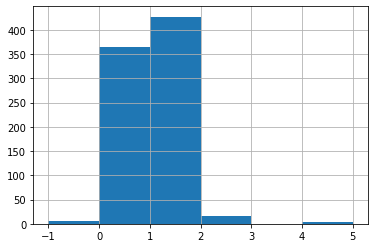

In [13]:
year_inside = re.compile(r'.*(19\d{2}|20\d{2}).*')
data['year_from_name'] = data['name'].apply(year_inside.match)
data['year_from_name'] = data['year_from_name'].apply(
    lambda x: int(x.group(1)) if x!= None else np.nan)

data_tmp = data.loc[(~data['year_from_name'].isna())&(~data['year_of_release'].isna())]
data_tmp['year_diff'] = data_tmp['year_from_name'] - data_tmp['year_of_release']
data_tmp['year_diff'].hist(range=(-1,5),bins=6)
plt.show()

Most of the names have year in name same as release or the next one. The second option slightly more frequent so we'll stick to the one year shift

In [14]:
data.drop('year_from_name', axis=1, inplace=True)
del data_tmp
gc.collect()

3018

Some kind of error led to missing values in 'year_of_release' column. We'll try to restore them based on the following
- Many games released simultaniously on different platforms
- Some games live a long life being reissued on the new platforms years after the first release
- Some games have a hint for the year of releasr in the name
- Games definitlly were released when there were releases with the same platform and more likely they were released when the platform was more popular
<br><br>
So the algorithm of filling the missing values in "year_of_release" is:
1. Check if the game was released on other platforms in the life span of current platform. If there are such releases replace with median year of those releases
2. Check if the name contains mention of the year. If it fits to platform life span replace with the year previous to the one mentioned in the name
3. Use maximum likelihood estimate conditioned on the platform for the rest.


In [15]:
# to define the range of years the platforms were active
min_release_year = (
    data.groupby('platform', as_index=False)
    .min()
    .set_index('platform')['year_of_release']
    .astype('int16')
    .to_dict()
)

max_release_year = (
    data.groupby('platform', as_index=False)
    .max()
    .set_index('platform')['year_of_release']
    .astype('int16')
    .to_dict()
)
# for maximum likelihood estimate
best_release_year = (
    data
    .groupby(['platform', 'year_of_release'], as_index=False)['name']
    .count()
    .sort_values('name', ascending=False)
    .drop_duplicates('platform')
    .drop('name', axis=1)
    .set_index('platform')['year_of_release']
    .astype('int16')
    .to_dict()
)

def fill_years_by_name(row):
     if np.isnan(row['year_of_release']):
        name = row['name']
        platform = row['platform']
        year_range = range(min_release_year[platform]
                           , max_release_year[platform] + 1)
        # Looking for other releases of the game in platform life span
        query = 'name == @name and year_of_release in @year_range'
        result = data.query(query)['year_of_release'].median()
        if np.isnan(result):
            # Looking for year mention in the name
            year_inside = re.compile(r'.*(19\d{2}|20\d{2}).*')
            match = year_inside.match(name)
            if match != None: 
                year_from_name = int(match.group(1)) - 1
                if year_from_name in year_range:
                    result = year_from_name
                # Maximum likelihood
                else:
                    result = best_release_year[platform]
            else:
                result = best_release_year[platform]
        return result
     return row['year_of_release']

data['year_of_release'] = data.apply(fill_years_by_name, axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [16]:
data[data['year_of_release'].isna()].shape

(0, 11)

In [17]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000
mean,2006.465057,0.263302,0.145045,0.077625,0.047343,68.967679
std,5.904364,0.813565,0.503359,0.308871,0.186742,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [18]:
data.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [19]:
data.query('user_score == "tbd"').shape

(2424, 11)

We have np.nan values and 'tbd' ("to be determined") in 'user_score' column. For our task there is no difference between nan and tbd - we lack the information in both cases. Thus we'll use the marker of -1 for them.

In [20]:
data['user_score'] = data['user_score'].fillna('tbd').apply(lambda x: -1.0 if x == 'tbd' else float(x))
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,-1.0,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,-1.0,NaN


In [21]:
data.critic_score.unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

critic scores are actually ints. We replace missing data with the same -1 marker

In [22]:
data['critic_score'] = data['critic_score'].fillna(-1).astype('int8')

In [23]:
data.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [24]:
data.query('rating == "RP"').shape

(3, 11)

In [25]:
data.query('rating == "RP"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13672,Clockwork Empires,PC,2011.0,Strategy,0.0,0.04,0.0,0.00,58,3.8,RP
14270,Supreme Ruler: Cold War,PC,2011.0,Strategy,0.0,0.03,0.0,0.01,63,6.8,RP
16180,WRC: FIA World Rally Championship,PC,2005.0,Racing,0.0,0.01,0.0,0.00,65,-1.0,RP


It's kind of strange to have "RP" (stands for "rating pending") rating for the old games - really how long is it pending? So we'll treat them as missing values and assign them to the same category "None" as for missing values

In [26]:
data['rating'] = data['rating'].fillna('None').apply(lambda x: 'None' if x == 'RP' else x)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1,-1.0,None
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,None


In [27]:
data['year_of_release'] = data['year_of_release'].astype('int16')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,None
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,None


In [28]:
data.isna().any()

name               False
platform           False
year_of_release    False
genre              False
na_sales           False
eu_sales           False
jp_sales           False
other_sales        False
critic_score       False
user_score         False
rating             False
dtype: bool

let's add the column of total sales

In [29]:
data['total_sales'] = data[[c for c in data.columns if 'sales' in c]].apply(sum, axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,None,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,None,31.38


## Data analysis

In [30]:
to_plot = data.groupby('year_of_release')['total_sales'].count()
to_plot.tail(2)

year_of_release
2015    607
2016    502
Name: total_sales, dtype: int64

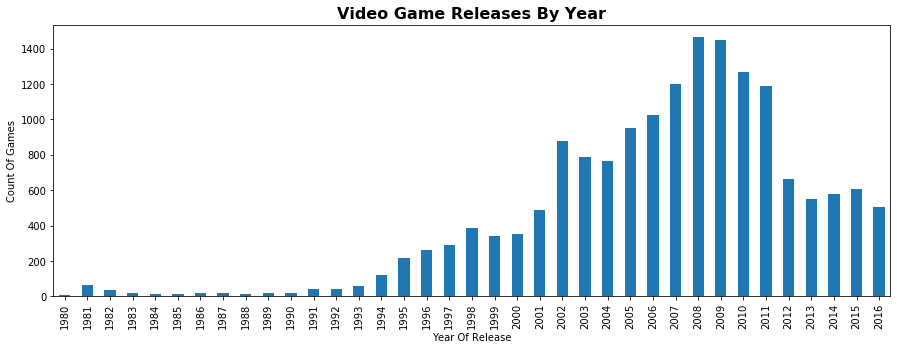

In [31]:
ax = to_plot.plot.bar(figsize=(15,5))
ax.set_title('Video Game Releases By Year', fontweight='bold', size=16)
ax.set_ylabel('Count Of Games', fontsize=10)
ax.set_xlabel('Year Of Release', fontsize=10)
plt.show()

As we can see from the plot above there wasn't any significant amount of releases before mid 90s. Then the popularity of the video games steadily raised to its peak in 2008-2009 years and finally the number of releases dropped to around the half of its best values in 2012 and more or less was flat till 2016. The drop in popularity of video games in 2012 most likely was due to the boom of the mobile gaming around the time.

In [32]:
platform_sales = data.groupby('platform')['total_sales'].sum().sort_values(ascending=True)
platform_sales.tail()

platform
DS       806.12
Wii      907.51
PS3      939.65
X360     971.42
PS2     1255.77
Name: total_sales, dtype: float64

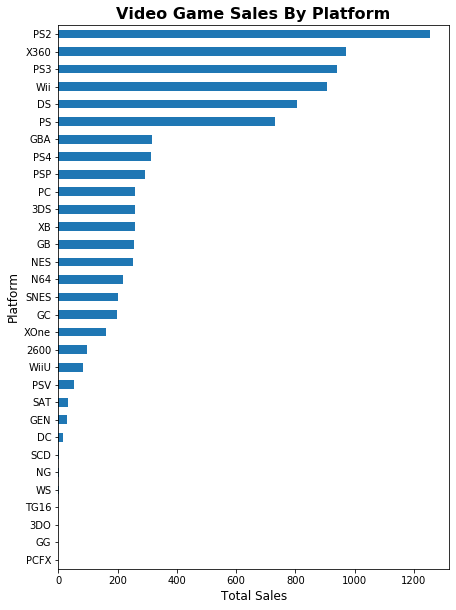

In [33]:
ax = platform_sales.plot.barh(figsize=(7,10))
ax.set_title('Video Game Sales By Platform', fontweight='bold', size=16)
ax.set_ylabel('Platform', fontsize=12)
ax.set_xlabel('Total Sales', fontsize=12)
plt.show()

Clearly we have 6 platforms leading in total sales 

In [34]:
popular_platforms = list(platform_sales.tail(6).index)
significant_platforms = list(platform_sales[platform_sales>100].index)
popular_platforms

['PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2']

In [35]:
def plot_sales_by_years(platforms, title='Total Sales Of Platforms Per Year Of Release'):
    n = len(platforms)
    to_plot =(
        data
        .query('platform in @platforms')
        .groupby(['platform', 'year_of_release'], as_index=False)['total_sales']
        .sum()
    )
    pivot = (
        pd.pivot_table(
            to_plot, values='total_sales'
            , columns=['platform']
            , index=['year_of_release']
        )
    )
    pivot.plot(kind='bar', subplots=True, sharex=True
               , layout=(n,1), figsize=(10,2*n), legend=True)
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.xlabel('Year Of Release', fontsize=12)
    plt.show()

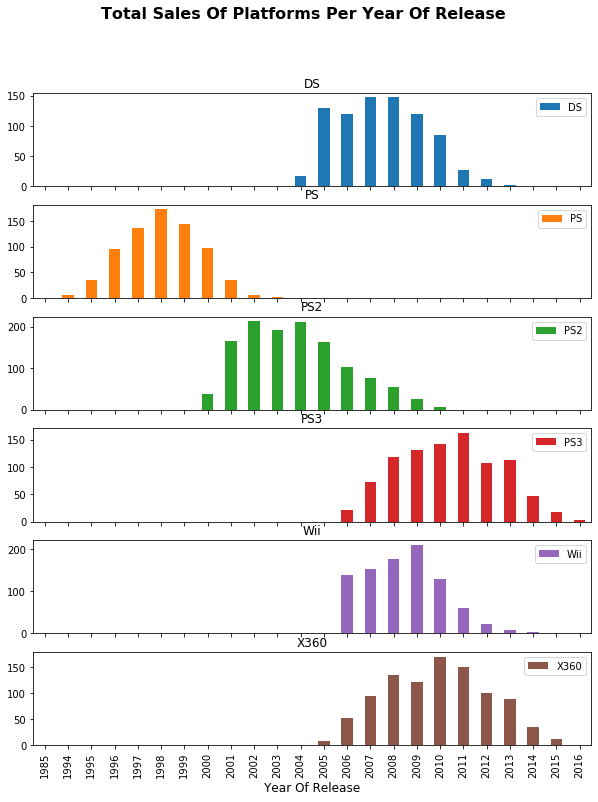

In [36]:
plot_sales_by_years(popular_platforms)

In [37]:
d = data.query('platform == "DS"').year_of_release.sort_values().unique()
np.diff(d)

array([19,  1,  1,  1,  1,  1,  1,  1,  1,  1])

We've detected an outlier for "DS" platform:

In [38]:
data.query('platform == "DS" and year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,-1,-1.0,None,0.02


Sales are small and insignificant, thus we just get rid of it

In [39]:
data.drop(
    data.query('platform == "DS" and year_of_release == 1985').index
    , inplace=True
)
min_release_year['DS'] = min(data.query('platform == "DS"').year_of_release.unique())
min_release_year['DS']

2004

As we can see from the plots above every platform has its lifespan when there are new releases on this platform. To predict patterns in 2017 we don't need to analyse the outdated platforms. So let's look into platform's lifespan more.

In [40]:
lifespan = data.groupby('platform', as_index=False)['year_of_release'].agg(['min', 'max'])
lifespan.columns

Index(['min', 'max'], dtype='object')

In [41]:
lifespan.columns = ['start', 'end']
lifespan.head()

,start,end
platform,,
2600,1980,1989
3DO,1994,1995
3DS,2011,2016
DC,1998,2008
DS,2004,2013


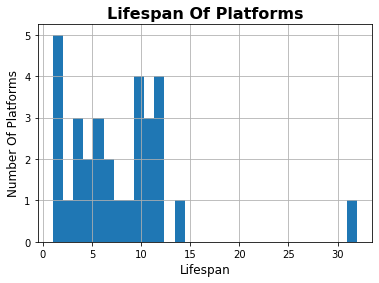

In [42]:
lifespan['lifespan'] = lifespan['end'] - lifespan['start'] + 1
ax = lifespan.lifespan.hist(bins=30)
ax.set_title('Lifespan Of Platforms', fontweight='bold', size=16)
ax.set_ylabel('Number Of Platforms', fontsize=12)
ax.set_xlabel('Lifespan', fontsize=12)
plt.show()

Most platforms stay actual no longer then 11 years

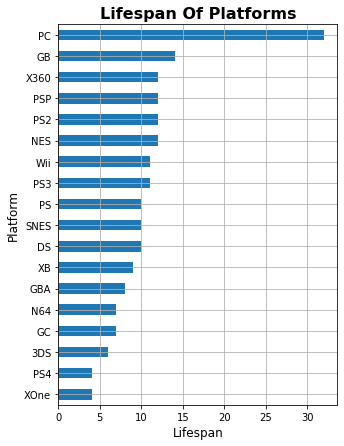

In [43]:
ax = (lifespan.query('platform in @significant_platforms')
 .lifespan.sort_values(ascending=True)
 .plot(kind='barh', figsize=(5,7), grid=True))
ax.set_title('Lifespan Of Platforms', fontweight='bold', size=16)
ax.set_ylabel('Platform', fontsize=12)
ax.set_xlabel('Lifespan', fontsize=12)
plt.show()

Let's take a look at the long lived platforms

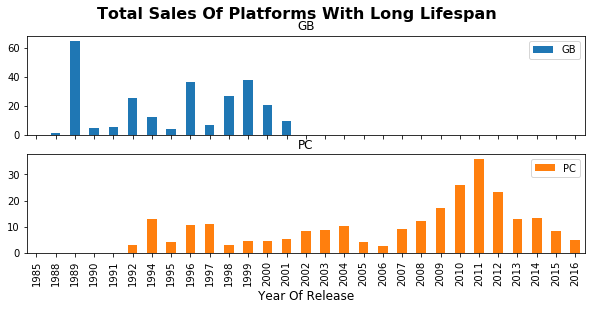

In [44]:
plot_sales_by_years(['PC', 'GB']
                    , title='Total Sales Of Platforms With Long Lifespan')

So "GB" is rather old platform and won't be interesting for us to predict sale patterns in 2017.
On the other hand "PC" platform with it's lifespan more then 30 years really stands out in the lifespan analysis. The new games keep releasing for PC for decades and we can't discard this platform based just on it's lifespan duration. Actually the reason of such a long lifespan is obvious - the Personal Computer platform keeps upgrading over the years with the computers while regular video games platforms are replaced with the new ones (like PS -> PS2 -> PS3 -> PS4)
<br><br>
Now we need to select the platforms we expect will have new releases in 2017. Firstly let's see which platform still had releases in 2016:

In [45]:
modern = (data.query('year_of_release == 2016 and platform in @significant_platforms')
          .groupby('platform')['total_sales'].sum())
modern_platforms = list(modern.index)

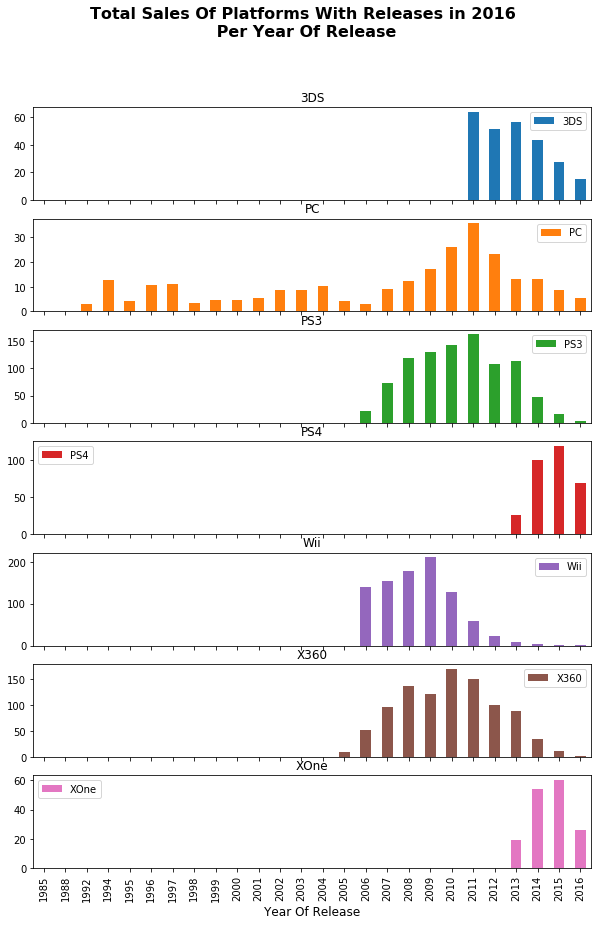

In [46]:
plot_sales_by_years(modern_platforms, title='Total Sales Of Platforms With Releases in 2016\n Per Year Of Release')

We can see that in this list some platforms are in the end of their lifespan and not likely will have any significant releases in 2017 (PC is exception as we mentioned earlier). From the plots we clearly see that total sales falls dramatically in the end of lifespan. How dramatically? 

Let's define the platform is rising if the total sales of the new year releases is higher then average sales of previous years.

In [47]:
tmp =(
        data
        .query('platform in @significant_platforms')
        .groupby(['platform', 'year_of_release'], as_index=False)['total_sales']
        .sum()
    )
tmp

,platform,year_of_release,total_sales
0,3DS,2011,63.99
1,3DS,2012,51.76
2,3DS,2013,56.57
3,3DS,2014,43.76
4,3DS,2015,27.78
...,...,...,...
179,XB,2008,0.18
180,XOne,2013,18.96
181,XOne,2014,54.07
182,XOne,2015,60.14


In [48]:
def is_raising(row):
    year = row['year_of_release']
    platform = row['platform']
    df = tmp.query('platform == @platform and year_of_release < @year')
    if df.shape[0] == 0:
        return True
    return row['total_sales'] > df['total_sales'].mean()
    

tmp['is_raising'] = tmp.apply(is_raising, axis=1)
tmp.head()

,platform,year_of_release,total_sales,is_raising
0,3DS,2011,63.99,True
1,3DS,2012,51.76,False
2,3DS,2013,56.57,False
3,3DS,2014,43.76,False
4,3DS,2015,27.78,False


In [49]:
tmp.query('platform == "XOne"')

,platform,year_of_release,total_sales,is_raising
180,XOne,2013,18.96,True
181,XOne,2014,54.07,True
182,XOne,2015,60.14,True
183,XOne,2016,26.15,False


In [50]:
raising_platforms = tmp.drop(tmp[~tmp['is_raising']].index)
raising_platforms.shape

(97, 4)

In [51]:
to_plot = pd.pivot_table(
            raising_platforms, values='is_raising'
            , columns=['year_of_release']
            , index=['platform']
        ).fillna(0).astype(int)
to_plot.head()

year_of_release,1983,1984,1985,1988,1989,1990,1992,1993,1994,1995,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
platform,,,,,,,,,,,,,,,,,,,,,
3DS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
DS,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
GB,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GBA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<function matplotlib.pyplot.show(*args, **kw)>

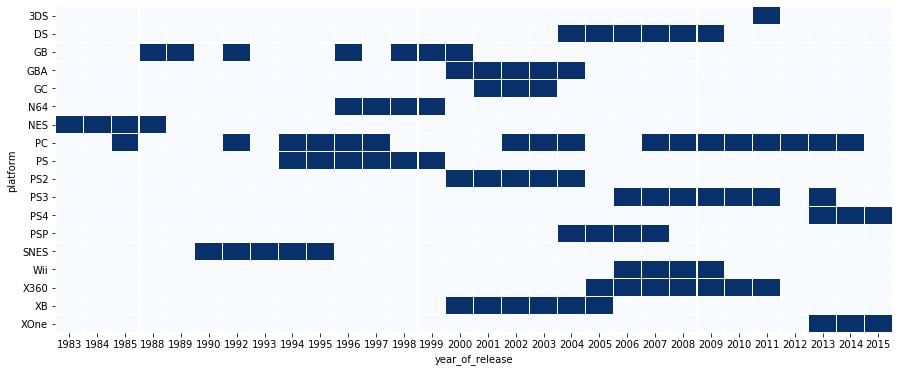

In [52]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.heatmap(to_plot, cbar=False, cmap='Blues', linewidth=0.1)
plt.show

With the exception of PC platform we can see that platforms stay active for 6-7 years maximum and the new platform usually appears the next year or the year after next of the point when the sales of the old one dropped below average sales. 
<br><br>
One more thing - on the chart above we can see that there is no raising platforms in 2016. This is due to the fact that actual sales of the games released in 2016 will occur not only in 2016 but in 2017 and even in 2018. Thus we can expect that platforms PS4 and XOne being raising ones in 2015 and having just 3 year of the raising will keep the raising trend in 2016 after the sales numbers for 2017 becomes available

One more thing we need to check if there is any brand new platform that has small sales just due to its novelty?

In [53]:
lifespan.query('start >= 2015').shape[0]

0

Well there is none.

In [54]:
data.shape, data.query('year_of_release > 2011').shape

((16712, 12), (2900, 12))

To build a prognosis for 2017 we shouldn't use the whole data because the customer's preferences are changing over time and we benifit more from analysing the recent data then from discovering any preference patterns in 90s. Our analysis so far showed that there appeared a new overall video games sale pattern around 2012 when sales dropped significantly from it's peak in 2008-2009. On the other hand we discovered that any new platform keeps its popularity for 6-7 years top and a lot of platforms were on raising trend just 4 or 5 years. It shows how fast the players preferences could change. Based on it we consider period of 5 years to be relevant for our following analysis.

In [55]:
modern_data = data.query('year_of_release > 2011').copy()

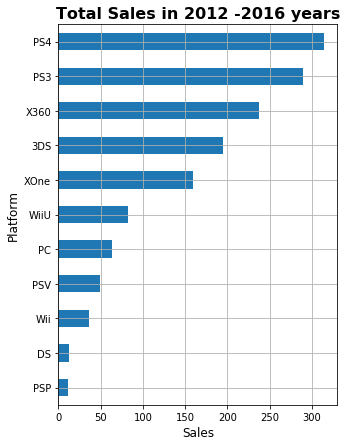

In [56]:
ax = (
    modern_data
    .groupby('platform')['total_sales']
    .sum()
    .sort_values()
    .plot(kind='barh', figsize=(5,7), grid=True)
)
ax.set_title('Total Sales in 2012 -2016 years', fontweight='bold', size=16)
ax.set_ylabel('Platform', fontsize=12)
ax.set_xlabel('Sales', fontsize=12)
plt.show()

From previous studies we know that PS4 and XOne are the raising platforms in 2016 while PS3 and X360 are outdated and most likely won't show significant sales in 2017... 3DS platform even being relatively new platform failed to show steady growth in sales after its appearence in 2011 so we won't expect any growth in it in 2017 either.

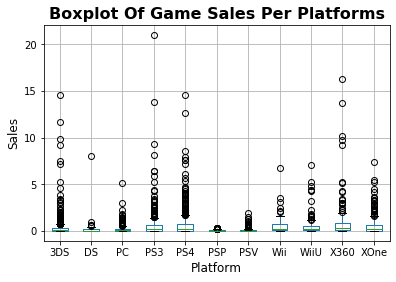

In [57]:
ax = modern_data.boxplot(column='total_sales', by='platform')
plt.suptitle('')
ax.set_title('Boxplot Of Game Sales Per Platforms', fontweight='bold', size=16)
ax.set_ylabel('Sales', fontsize=12)
ax.set_xlabel('Platform', fontsize=12)
plt.show()

We can see that there were hits in almost every platforms with much grater sales then average game has.

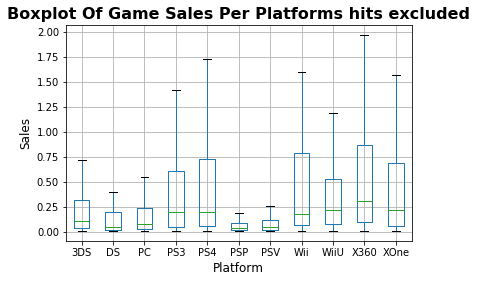

In [58]:
ax = modern_data.boxplot(column='total_sales', by='platform', showfliers=False)
plt.suptitle('')
ax.set_title('Boxplot Of Game Sales Per Platforms hits excluded', fontweight='bold', size=16)
ax.set_ylabel('Sales', fontsize=12)
ax.set_xlabel('Platform', fontsize=12)
plt.show()

From the boxplot we can see that X360 is undisputed leader of average sales. Next after it goes PS3, PS4, Wii, WiiU and XOne - both perspective platforms (PS4 and XOne) in this group. And as could be expected PSP and PSV platforms are in the end of the list - they are mobile consoles.

In [59]:
popular_platforms = list(modern_data
                         .groupby('platform')['total_sales']
                         .sum()
                         .sort_values(ascending=False)
                         .head(5)
                         .index
                        )
popular_platforms

['PS4', 'PS3', 'X360', '3DS', 'XOne']

Let's see how critic score and user score influence on sales of the game. First let's take a look at if the existence of score can tell us something about total sales.

In [60]:
modern_data['has_critic_score'] = modern_data['critic_score'] > 0
modern_data['has_user_score'] = modern_data['user_score'] > 0

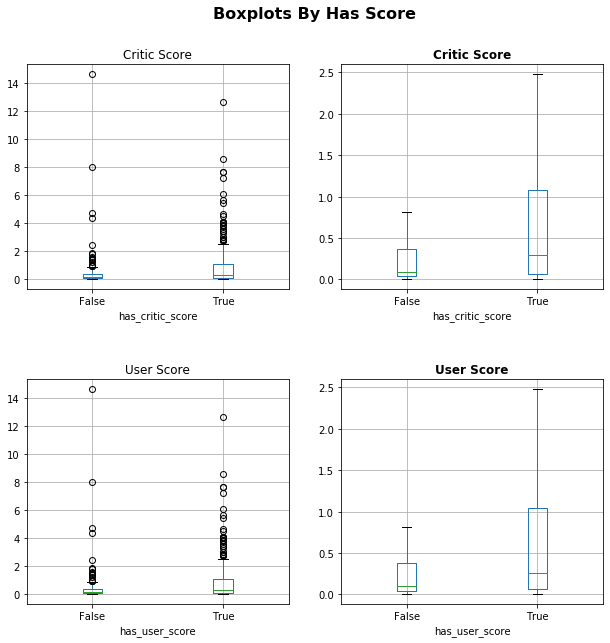

In [61]:
fig, axes = fig, axes = plt.subplots(2,2, figsize=(10,10))
fig.subplots_adjust(wspace=.2, hspace=.4)
to_plot = modern_data.query('platform == "PS4"')
for i, has_score in enumerate(['has_critic_score', 'has_user_score']):
    name = has_score.replace('_', ' ').title()[4:]
    to_plot.boxplot(column='total_sales'
                                 , by=has_score
                                 , showfliers=True, ax=axes[i,0])
    axes[i,0].set_title(f'{name}')
    to_plot.boxplot(column='total_sales'
                                 , by=has_score
                                 , showfliers=False, ax=axes[i,1])
    axes[i,1].set_title(f'{name}', fontweight='bold')
plt.suptitle('Boxplots By Has Score', fontweight='bold', size=16)
plt.show()

From the boxplots above we can see that even though on average games with critic or user score have higher sales the top selling game have no score at all.
<br><br>
Let's move to corelation between total sales and actual score numbers

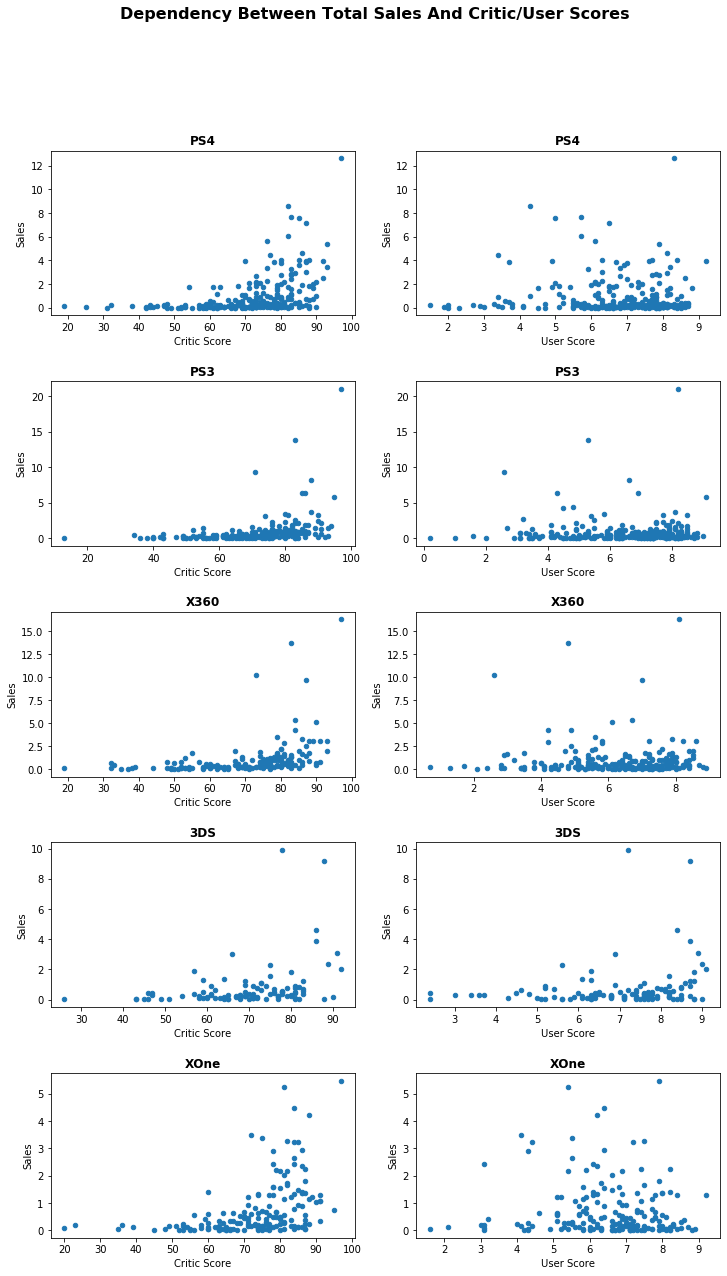

In [62]:
n = len(popular_platforms)
corr = pd.DataFrame(index=popular_platforms, columns=['corr_critic_score', 'corr_user_score'])
fig, axes = plt.subplots(n, 2, figsize=(12,4*n))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, platform in enumerate(popular_platforms):
    # Plot for Critic Score
    (modern_data
     .query('platform == @platform and has_critic_score')
     .plot(kind='scatter', x='critic_score', y='total_sales', ax=axes[i,0])
    )
    axes[i,0].set_title(platform, fontweight='bold', size=12)
    axes[i,0].set_xlabel('Critic Score')
    axes[i,0].set_ylabel('Sales')
    # Correlation for Critic Score
    corr.loc[platform, 'corr_critic_score'] = (
         modern_data.query('platform == @platform and has_critic_score')['total_sales']
        .corr(modern_data.query('platform == @platform and has_critic_score')['critic_score'])
       )
    
    # Plot for User Score
    (modern_data
     .query('platform == @platform and has_user_score')
     .plot(kind='scatter', x='user_score', y='total_sales', ax=axes[i,1])
    )
    axes[i,1].set_title(platform, fontweight='bold', size=12)
    axes[i,1].set_xlabel('User Score')
    axes[i,1].set_ylabel('Sales')
    # Correlation for User Score
    corr.loc[platform, 'corr_user_score'] = (
         modern_data.query('platform == @platform and has_user_score')['total_sales']
        .corr(modern_data.query('platform == @platform and has_user_score')['user_score'])
       )

plt.suptitle('Dependency Between Total Sales And Critic/User Scores', fontweight='bold', size=16)
plt.show()
    

In [63]:
corr

,corr_critic_score,corr_user_score
PS4,0.406568,-0.0319571
PS3,0.331371,-0.00504305
X360,0.360266,0.00631494
3DS,0.320458,0.19815
XOne,0.416998,-0.0689251


The correlation coefficient confirms what we can see from scatter plots above - there is no correlation between user scores and total sales and there is moderate positive correlation between critic review scores and total sales of the game. Scatter plots implies that dependensy here most likely non linear (critic scores) thus coefficient of correlation not fully catch it. But anyway we may conclude that there is positive correlation here.

Now let's take a look at how correlated the sales of the same games on different platforms:

In [64]:
corr_mat = pd.DataFrame(index=popular_platforms, columns=popular_platforms)
for platform1 in popular_platforms:
    for platform2 in popular_platforms:
        df = (
            modern_data
            .query('platform == @platform1')[['name', 'total_sales']]
            .merge(modern_data.query('platform == @platform2')[['name', 'total_sales']]
                   , on='name', how='left')
            .dropna()
        )
        corr_mat.loc[platform1, platform2] = df['total_sales_x'].corr(df['total_sales_y'])

corr_mat

,PS4,PS3,X360,3DS,XOne
PS4,1,0.655654,0.582291,0.345204,0.956158
PS3,0.655654,0.993849,0.953576,0.199632,0.606928
X360,0.582291,0.953576,1,0.370485,0.607948
3DS,0.345204,0.199632,0.370485,1,0.492727
XOne,0.956158,0.606928,0.607948,0.492727,1


Something went wrong - we shouldn't have PS3 - PS3 correlation anything but one!

In [65]:
df = (modern_data.query('platform == "PS3"')[['name', 'total_sales']]
            .merge(modern_data.query('platform == "PS3"')[['name', 'total_sales']], on='name', how='left')
            .dropna())
df.head(2)

,name,total_sales_x,total_sales_y
0,Grand Theft Auto V,21.05,21.05
1,Call of Duty: Black Ops II,13.79,13.79


In [66]:
df.query('total_sales_x != total_sales_y')

,name,total_sales_x,total_sales_y
18,Madden NFL 13,2.56,0.01
481,Madden NFL 13,0.01,2.56


In [67]:
modern_data.query('name == "Madden NFL 13" and platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,has_critic_score,has_user_score
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83,5.5,E,2.56,True,True
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83,5.5,E,0.01,True,True


In [68]:
modern_data.shape

(2900, 14)

In [69]:
modern_data.drop_duplicates(['name', 'platform', 'year_of_release'], inplace=True)
modern_data.shape

(2899, 14)

In [70]:
modern_data.query('name == "Madden NFL 13" and platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,has_critic_score,has_user_score
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83,5.5,E,2.56,True,True


fixed

In [71]:
corr_mat = pd.DataFrame(index=popular_platforms, columns=popular_platforms)
for platform1 in popular_platforms:
    for platform2 in popular_platforms:
        df = (
            modern_data
            .query('platform == @platform1')[['name', 'total_sales']]
            .merge(modern_data.query('platform == @platform2')[['name', 'total_sales']]
                   , on='name', how='left')
            .dropna()
        )
        corr_mat.loc[platform1, platform2] = df['total_sales_x'].corr(df['total_sales_y'])

corr_mat

,PS4,PS3,X360,3DS,XOne
PS4,1,0.655654,0.582291,0.345204,0.956158
PS3,0.655654,1,0.958729,0.199632,0.606928
X360,0.582291,0.958729,1,0.370485,0.607948
3DS,0.345204,0.199632,0.370485,1,0.492727
XOne,0.956158,0.606928,0.607948,0.492727,1


We can see that competing platforms like PS3 - X360 and PS4 - XOne have got more then 95 percent correlation in sales, old-new platforms like PS3-PS4 and X360-XOne have got moderate to strong correlation and the platform 3DS really stands aside having just weakly positive correlation with other platforms.

Let's move to the genres

In [72]:
modern_data.genre.unique()

array(['Action', 'Shooter', 'Role-Playing', 'Platform', 'Misc',
       'Simulation', 'Sports', 'Fighting', 'Racing', 'Strategy',
       'Adventure', 'Puzzle'], dtype=object)

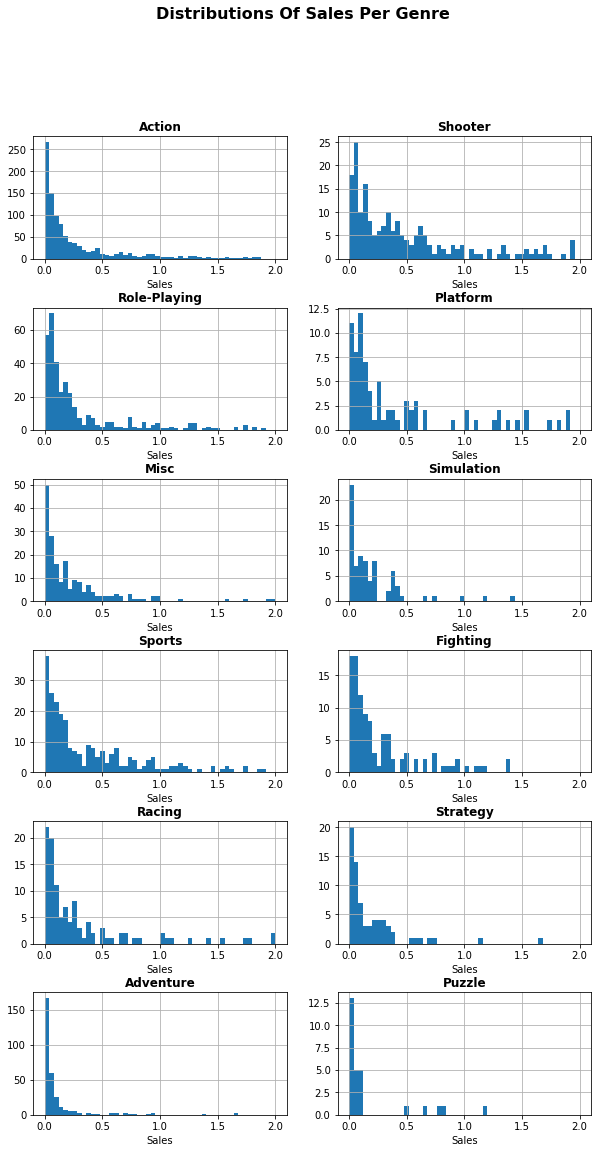

In [73]:
genres = list(modern_data.genre.unique())
fig, axes = plt.subplots(6,2, figsize=(10,18))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, genre in enumerate(genres):
    modern_data.query('genre == @genre')['total_sales'].hist(bins=50, range=(0,2), ax=axes[i//2,i%2])
    axes[i//2,i%2].set_title(genre, fontweight='bold', size=12)
    axes[i//2,i%2].set_xlabel('Sales')
plt.suptitle('Distributions Of Sales Per Genre', fontweight='bold', size=16)
plt.show()

All distributions looks like exponential with different parameter $\lambda$ but for some genres like Puzzle it's just a guess due to the smallness of sample. Let's look at basic statistics:

In [74]:
modern_data.groupby('genre')['total_sales'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Shooter,237.0,1.285865,2.245201,0.01,0.13,0.430,1.4700,14.63
Platform,85.0,0.717647,1.364413,0.01,0.09,0.210,0.6600,9.90
Sports,267.0,0.678127,1.137778,0.01,0.08,0.240,0.7450,8.58
Role-Playing,371.0,0.520377,1.314227,0.01,0.06,0.140,0.4050,14.60
Racing,115.0,0.465217,0.888664,0.01,0.05,0.140,0.4200,7.09
Misc,193.0,0.441865,1.078327,0.01,0.03,0.120,0.3300,9.18
Simulation,80.0,0.439000,1.244500,0.01,0.03,0.120,0.3275,9.17
Action,1041.0,0.428828,1.161497,0.01,0.03,0.120,0.4000,21.05
Fighting,109.0,0.408165,0.910385,0.01,0.06,0.130,0.3600,7.55


In [75]:
modern_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

genre
Action          446.41
Shooter         304.75
Role-Playing    193.06
Sports          181.06
Misc             85.28
Platform         61.00
Racing           53.50
Fighting         44.49
Simulation       35.12
Adventure        29.43
Strategy         13.34
Puzzle            4.89
Name: total_sales, dtype: float64

We can draw several conclusions from the numbers above:
- The top genre in total sales "Action" take only average position in profitability per game. Both mean and median statistics for "Action" are in the lower half of the list. The success of total sales in the genre happens because of more then 1000 games released in this genre while the second place in number of games released goes to "Role-Playing" with "only" 371 games.
- The top genre in profitability is "Shooter". The gap from the second place is huge - more then twice sales for median game and almost two times for mean. It means that for most games issued in this genre we could expect higher then average sales in 2017
- The second genre in profitability is "Platform". The new releases are rare in the genre but we can expect good sales for them.
- "Role-Playing" and "Sports" are steady choices both in overall sales and profitability per game. Sports has a high median and low max meaning that there is no big hits in the genre but it has its loyal fans and most of the games issued got reasonable sales. "Role-Playing" on the other hand is completely another story - the genre has a lot of big sale gems in it which make an average sales in genre high but if we cut off those big successes the genre sales becomes average at best - the low number in median tells it. One shouldn't bet money on the success of the game issued in this genre automatically - a lot of them will be a failure but the thorough analisis of the games in Role-Playing could bring us to discovering more about what games could become a new hit in 2017.
- "Strategy", "Puzzle" and "Advanture" are clear outsiders in both lists and the low numbers in the max column tells us that there wasn't any single one good hit in the genres for the last 6 years. Rather sad news for the fans of strategy games :)

## User profile for each region

In [76]:
# Totals for sales per region
na_total = modern_data['na_sales'].sum()
eu_total = modern_data['eu_sales'].sum()
jp_total = modern_data['jp_sales'].sum()
na_total, eu_total, jp_total

(593.41, 509.22, 192.89)

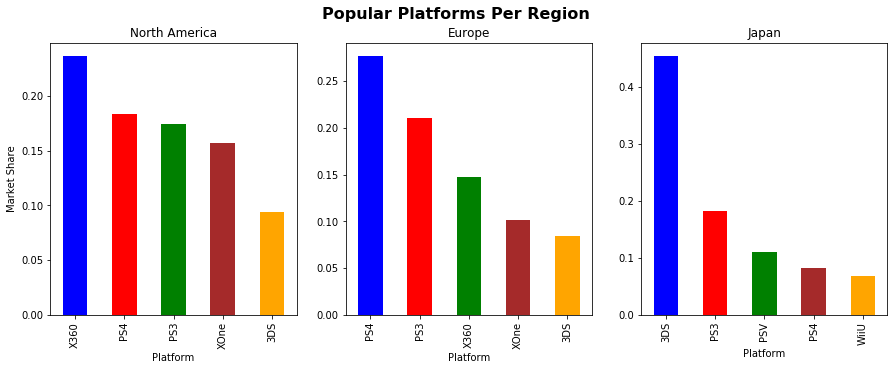

In [77]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
titles = ['North America', 'Europe', 'Japan']
region_market = [na_total, eu_total, jp_total]
colors = ['blue', 'red', 'green', 'brown', 'orange']
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, region in enumerate(regions):
    (modern_data
     .groupby('platform')[region]
     .sum()
     .apply(lambda x: x / region_market[i])
     .sort_values(ascending=False)
     .head(5)
     .plot(kind='bar', ax=axes[i], color=colors)
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Platform')
axes[0].set_ylabel('Market Share')
plt.suptitle('Popular Platforms Per Region', fontweight='bold', fontsize=16)
plt.show()

The user preferences in platforms are similar for North America and Europe - we have the same top 5 platforms in these regions. But there are some differences too - in Europe PS-family platforms more popular over X-family, PS3 and PS4 combined took almost 50% of the Europe market. In North America on the contrary X-family platforms more popular and X360, XOne take around 40% of the market. 3DS platform is the least popular of top5 platforms in these regions - it took just a bit under 10% share of total sales. <br>
Japan region shows completely different picture of the user preferences in game platforms - 3DS platform catch almost 50% of the market while X-family didn't make it to the top 5 platforms at all. Instead we can see in top 5 upopular platforms unpopular in Europe and North America PSV and WiiU <br><br>
One other thing to mention as for this plot is that North America users are the least extream in there preferences - the most popular platform take less then 25% of the market share, while almost half of the Japan sales happens in one platform 3DS.

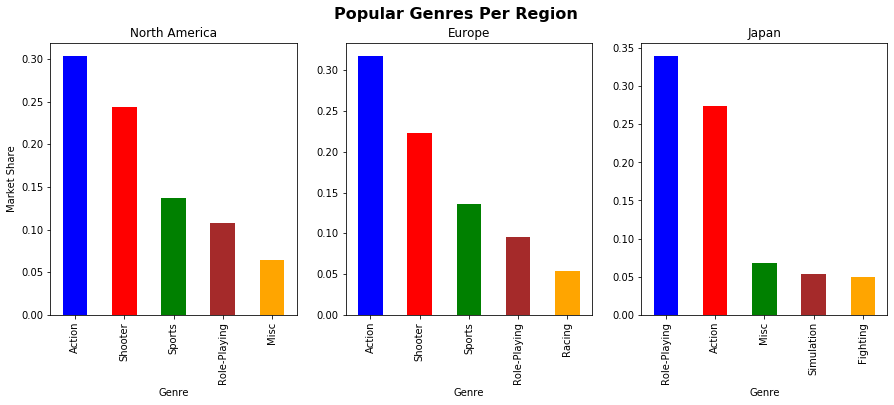

In [78]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, region in enumerate(regions):
    (modern_data
     .groupby('genre')[region]
     .sum()
     .apply(lambda x: x / region_market[i])
     .sort_values(ascending=False)
     .head(5)
     .plot(kind='bar', ax=axes[i], color=colors)
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Genre')
axes[0].set_ylabel('Market Share')
plt.suptitle('Popular Genres Per Region', fontweight='bold', fontsize=16)
plt.show()

As we can see there is almost no difference in genre preferences for users from North America and Europe: top 4 genres are the same and in the same order for these two regions. But Japan is another case. In Japan Role-playing sales take almost 35% of the market being a top-selling genre while in Europe it's only 4-th with market share about 10%. Second best genre in EU/NA "Shooters" didn't make it to the top 5. in Japan meaning market share for the "Shooters" less then 5% in Japan instead of solid 20+ percent in EU/NA. "Action" is in the top 2 everywhere, but we remember that "Action" has no big hits in it - there are a lot of games released in the genre making overall sales high regardles of region. <br>
One more thing to mention - Japan market seems much more genre concentrated - more then 60% of sales are in the top 2 genres and all the others have significantly less then 10% market share.

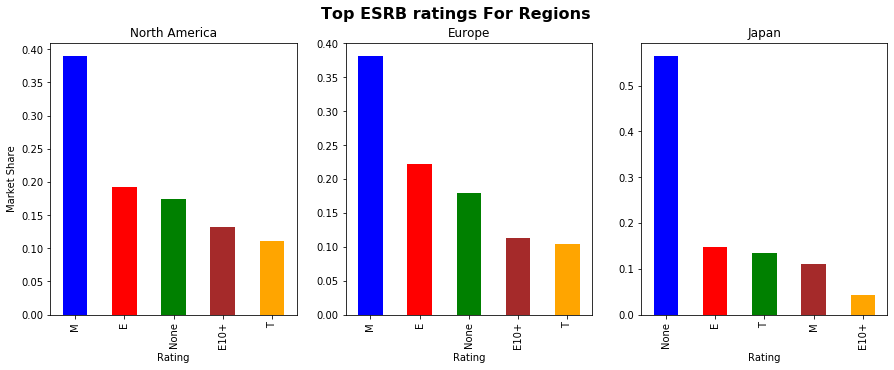

In [79]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, region in enumerate(regions):
    (modern_data
     .groupby('rating')[region]
     .sum()
     .apply(lambda x: x / region_market[i])
     .sort_values(ascending=False)
     .plot(kind='bar', ax=axes[i], color=colors)
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Rating')
axes[0].set_ylabel('Market Share')
plt.suptitle('Top ESRB ratings For Regions', fontweight='bold', fontsize=16)
plt.show()

In all regions top 5 selling ESRB ratings are the same. However again Japan stands apart from Europe and North America. While in Europe and North America the order of the top 5 raings is the same and the market shares are close in Japan more then 50% of sales goes in "No Rating" category. For EU/NA users it seems to be importent the existence of the rating - less then 20% sales happens in games without rating.<br><br>
In EU/NA we can drow some conclusions like the most selling category of games is the games with the ESRB rating "M" (mature), the next "E" (everyone) and so on. But even in these regions we can't say that ESRB rating affect sales somehow - we could see some patterns and correlations in data but the question of causality can't be answered based on the available data. We can't say if the specific top-selling game with rating "M" had any less sales figures in case it wasn't rated at all. <br><br>
In Japan we shouldn't draw any conclusions from the plot above, but the single one - to sell in Japan there is no need to rate the game. Most likely those games with rating achieved some sales in Japan was rated for sales in Europe or North America. And having more then 50% sales in games without rating we can't reasonably guess what kind of games were best selling in Japan (for kids (E), for mature (M) or teens (T)) - to much data was left unrated.

## Hypothesis testing

We were asked to check two hypothesis based on given dataset:
1. Average user ratings of the Xbox One and PC platforms are the same.
2. Average user ratings for the Action and Sports genres are different.

### Average user ratings of the Xbox One and PC platforms are the same

To check the hypothesis we formulate:<br>
H0: Average user ratings of the Xbox One and PC platforms are the same<br>
H1: Average user ratings of the Xbox One and PC platforms are different<br>
Our data should either reject the null hypothesis or fail to reject. <br>
We should set the level of confidence for our decision prior doing any tests. Our hypothesis isn't the one with life or death significance, that's why the conventional level of alpha for this kind of hypothesis testing is 5% (corresponds to 95% confidence level). Thus we'll use alpha = 0.05

lets take a look at the distributions of the user ratings in question

In [80]:
XOne_ratings = modern_data.query('platform == "XOne" and user_score > 0')['user_score']
PC_ratings = modern_data.query('platform == "PC" and user_score > 0')['user_score']
XOne_ratings.shape, PC_ratings.shape

((182,), (211,))

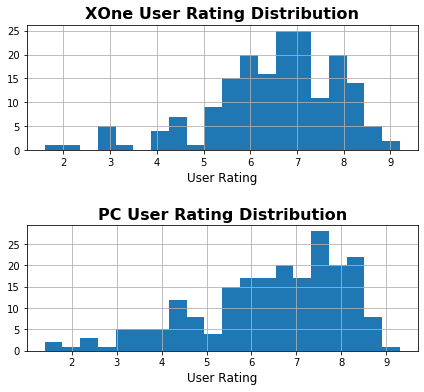

In [81]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
fig.subplots_adjust(wspace=.2, hspace=.6)
XOne_ratings.hist(bins=20, ax=axes[0])
axes[0].set_title('XOne User Rating Distribution', fontweight='bold', fontsize=16)
axes[0].set_xlabel('User Rating', fontsize=12)
PC_ratings.hist(bins=20, ax=axes[1])
axes[1].set_title('PC User Rating Distribution', fontweight='bold', fontsize=16)
axes[1].set_xlabel('User Rating', fontsize=12)
plt.show()

In [82]:
XOne_ratings.var(), PC_ratings.var()

(1.9069968429360695, 2.747158203565786)

The histograms above shows rather different shapes. PC user rating distribution looks consideraby more left-skewed then Xbox One one. Moreover the estimation of the variances differs significantly too. <br> <br>
We have rather big samples to test (much more then 30 in both cases) thus we may use standard t-test to test the hypothesis

In [83]:
alpha = .05 
results = st.ttest_ind(XOne_ratings, PC_ratings, equal_var=False)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  0.6206366351489678
We can't reject the null hypothesis


Based on given data we can't reject the hypothesis that average user ratings of the Xbox One and PC platforms are the same.

### Average user ratings for the Action and Sports genres are different.

To check the hypothesis we formulate:<br>
H0: Average user ratings for the Action and Sports genres are the same<br>
H1: Average user ratings for the Action and Sports genres are different<br>
Our data should either reject the null hypothesis or fail to reject.<br>
We should set the level of confidence for our decision prior doing any tests. Our hypothesis isn't the one with life or death significance, that's why the conventional level of alpha for this kind of hypothesis testing is 5% (corresponds to 95% confidence level). Thus we'll use alpha = 0.05

In [84]:
action_ratings = modern_data.query('genre == "Action" and user_score > 0')['user_score']
sports_ratings = modern_data.query('genre == "Sports" and user_score > 0')['user_score']
action_ratings.shape, sports_ratings.shape

((531,), (194,))

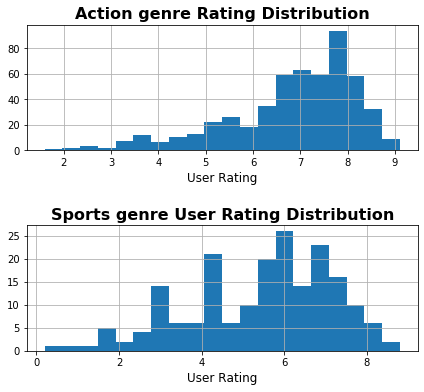

In [85]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
fig.subplots_adjust(wspace=.2, hspace=.6)
action_ratings.hist(bins=20, ax=axes[0])
axes[0].set_title('Action genre Rating Distribution', fontweight='bold', fontsize=16)
axes[0].set_xlabel('User Rating', fontsize=12)
sports_ratings.hist(bins=20, ax=axes[1])
axes[1].set_title('Sports genre User Rating Distribution', fontweight='bold', fontsize=16)
axes[1].set_xlabel('User Rating', fontsize=12)
plt.show()

In [86]:
action_ratings.var(), sports_ratings.var()

(1.8819173506733466, 3.0385428128839274)

Like with the previous hypothesis we have different shapes in distributions of the samples and significantly different variance estimations

In [87]:
results = st.ttest_ind(action_ratings, sports_ratings, equal_var=False)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  3.3183730691020334e-20
We reject the null hypothesis


Based on the given data we confirm that average user ratings for the Action and Sports genres are different. Considering the p-value of our test we can be confident in our decision much more then 95%.

<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Well done :)

It is not a very good idea to decide if variances are different by just comparing them. We can and should test if they are different and determine how significant is their difference. To test if variances are different you can use Levene's test.

Just for you to know: there are some works that suggest that there is no need in testing variances (before testing difference in means) and you can always assume that variances are different (and just keep `equal_var` parameter turned off all the time). But I think that it is better to follow standard procedure in this case (for educational purpose).

Also, if you observe that samples do not follow normal distribution (can be tested as well), you can test hypothesis for equal means with Man Whitney U test. It is a non parametric test, and thus it can work with any distribution.

------------

## Overall conclusion

In this project we explored the data of videogames sales. We were given the historical data on game sales from 1980 to 2016 and was asked to discover some patterns in the data the online store could use to plan 2017 sales and check two hypothesis.
- We preprocessed the data. Replaced the missing year_of_release data based on other information we had and marked missing data of scores and ratings with markers for later exploration
- We explored how the combined sales of the videogames evolved over time and how different platforms fared. Based on this exploration we choose the time interval of 5 years as best fitted for prediction patterns for 2017 sales.
- We discovered that only two platforms XOne and PS4 are in the raising state in 2016 and most likely will continue the uptrend in 2017
- We found five most popular platform  in the last 5 years of the data and later discovered that each region has its own preferences in these platforms. So in North America most popular is Xbox series, in Europe Play Stations and 3DS in Japan
- We discovered that the existence of critic and user scores is good for total game sales. And there is positive correlation between critic review scores and total sales of the game. But there is no such correlation for user scores.
- we've drawn several conclusions for the global sales in different genres and later on discovered principal difference in users genre preference between Japan and other regions
- we failed to reject that average user ratings of the Xbox One and PC platforms are the same, meaning that it is possibly the case at least the given data fit to it quite well
- and finally we confirmed that average user ratings for the Action and Sports genres are different with pretty high confidence.

<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Good :)

------------